In [145]:


# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

df=pd.read_csv('/kaggle/input/pjme-hourly/PJME_hourly.csv')
df.head()
df=df.set_index('Datetime')
df.columns


Index(['PJME_MW'], dtype='object')

Index(['PJME_MW'], dtype='object')

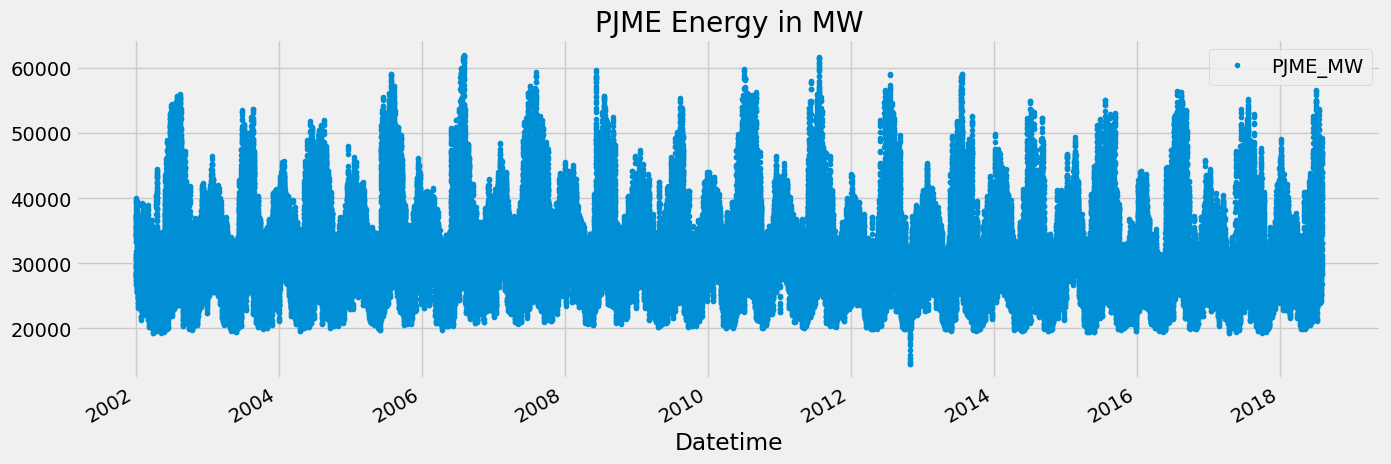

In [146]:
df.head()
color_pal=sns.color_palette()
df.index = pd.to_datetime(df.index)
df.plot(style='.',figsize=(15,5),color=color_pal[0], title='PJME Energy in MW')
df.columns


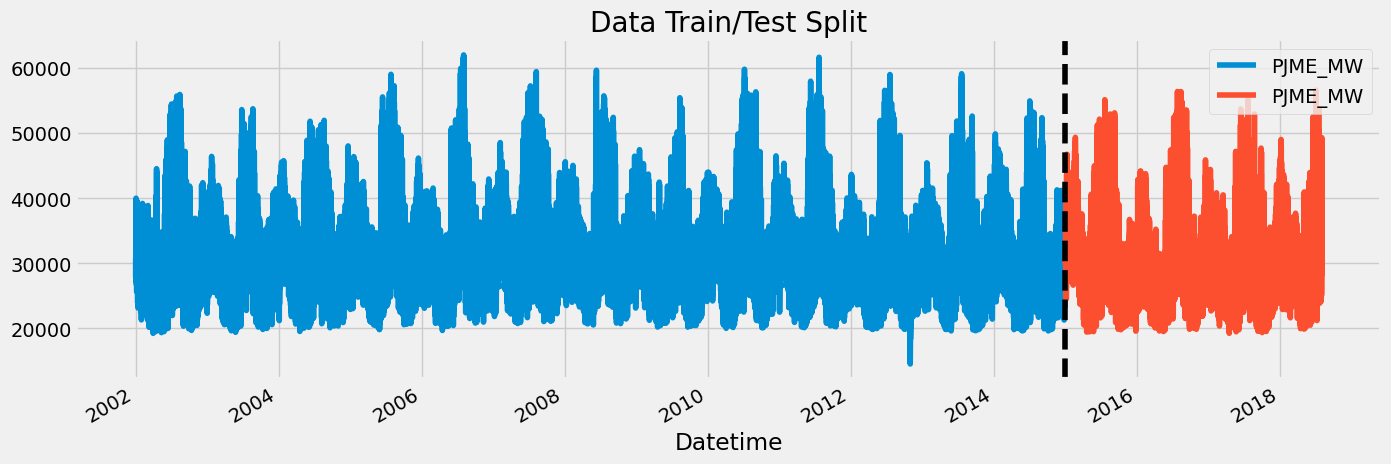

In [147]:
train= df.loc[df.index < '01-01-2015']
test = df.loc[df.index >='01-01-2015']
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set' , title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
plt.show()

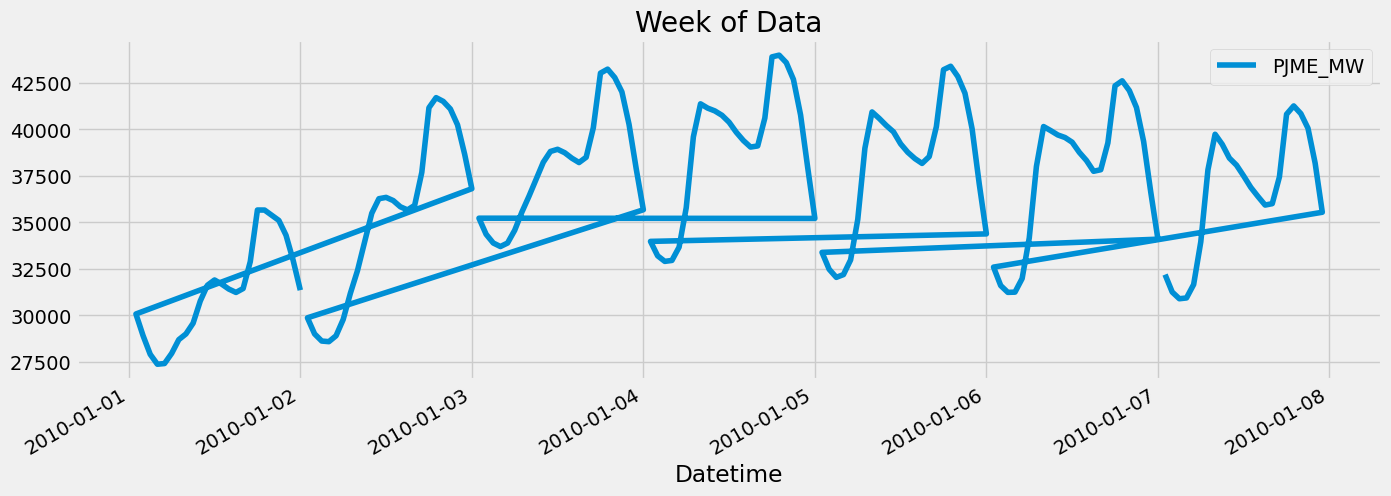

Datetime
2002-12-31 01:00:00    26498.0
2002-12-31 02:00:00    25147.0
2002-12-31 03:00:00    24574.0
2002-12-31 04:00:00    24393.0
2002-12-31 05:00:00    24860.0
                        ...   
2018-01-01 20:00:00    44284.0
2018-01-01 21:00:00    43751.0
2018-01-01 22:00:00    42402.0
2018-01-01 23:00:00    40164.0
2018-01-02 00:00:00    38608.0
Name: PJME_MW, Length: 145366, dtype: float64

In [148]:
df.loc[(df.index > '01-01-2010') & (df.index<'01-08-2010')].plot(figsize=(15,5) , title= 'Week of Data')
plt.show()
df.PJME_MW


In [149]:
def create_features(df):
    df=df.copy()
    df['hour']=df.index.hour
    df['dayofweek']=df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year']= df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df=create_features(df)



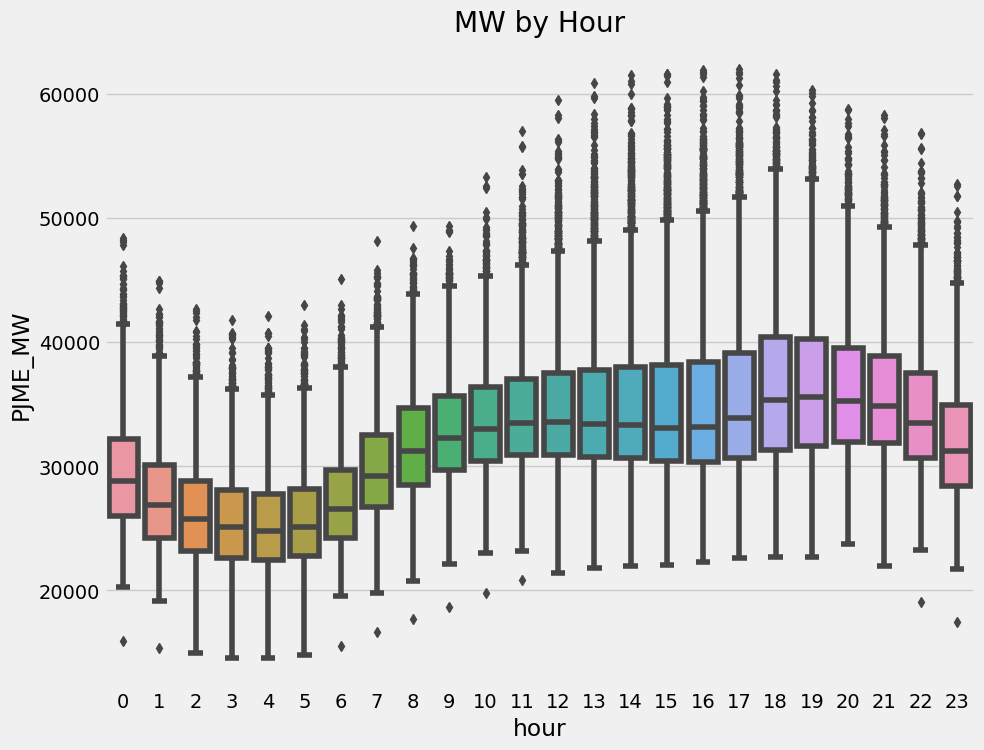

In [150]:
fig, ax= plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

In [151]:
train = create_features(train)
test = create_features(test)
FEATURES=['hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear']
TARGET='PJME_MW'


In [152]:

X_train=train[FEATURES]
y_train=train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]


[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.76687
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.93340
[417]	validation_0-rmse:2801.66222	validation_1-rmse:3749.26089


<Axes: title={'center': 'Feature Importance'}>

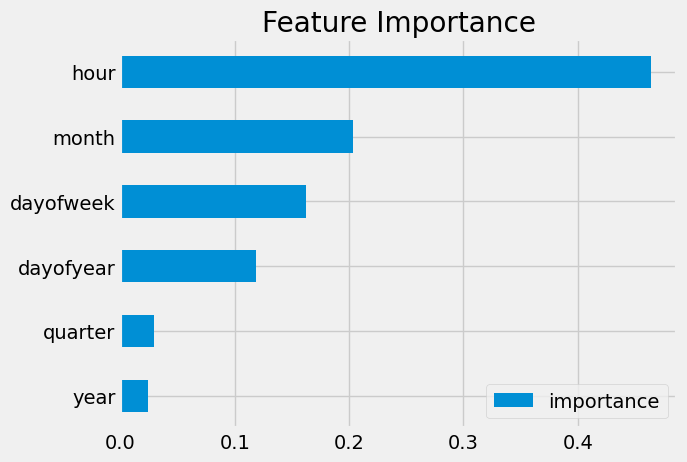

In [153]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds = 50, learning_rate=0.01)
reg.fit(X_train, y_train,
      eval_set = [(X_train,y_train),(X_test,y_test)],
      verbose=100)
fi=pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_,columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')

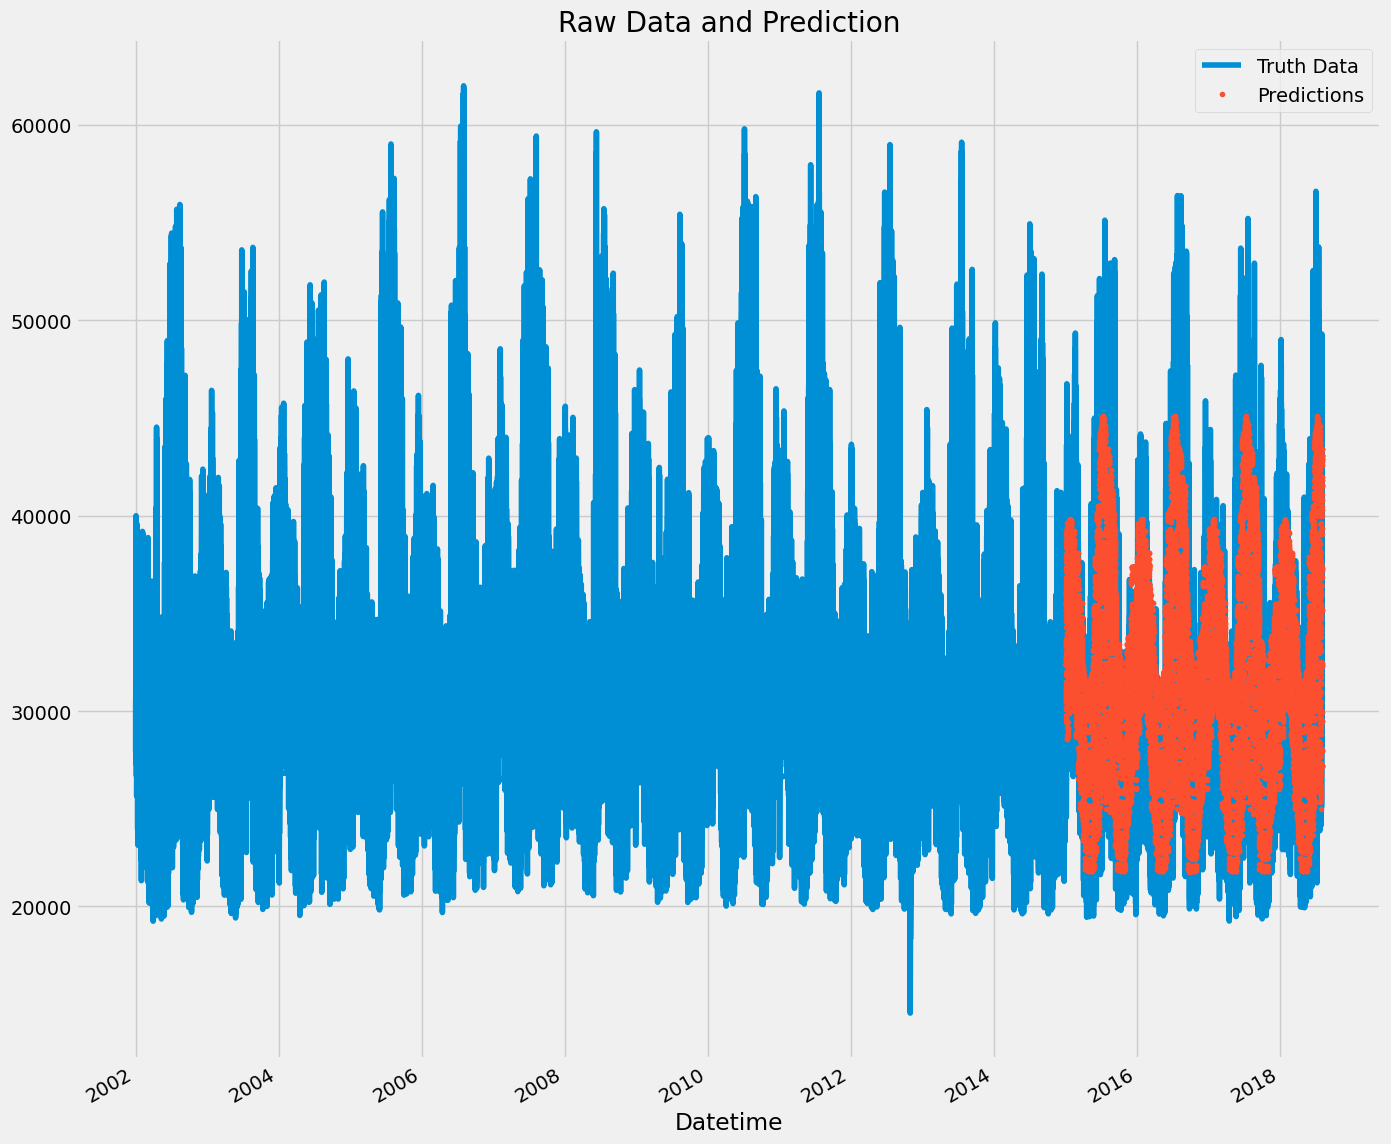

In [157]:
test['prediction'] = reg.predict(X_test)
df=df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax= df[['PJME_MW']].plot(figsize=(15,15))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data','Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

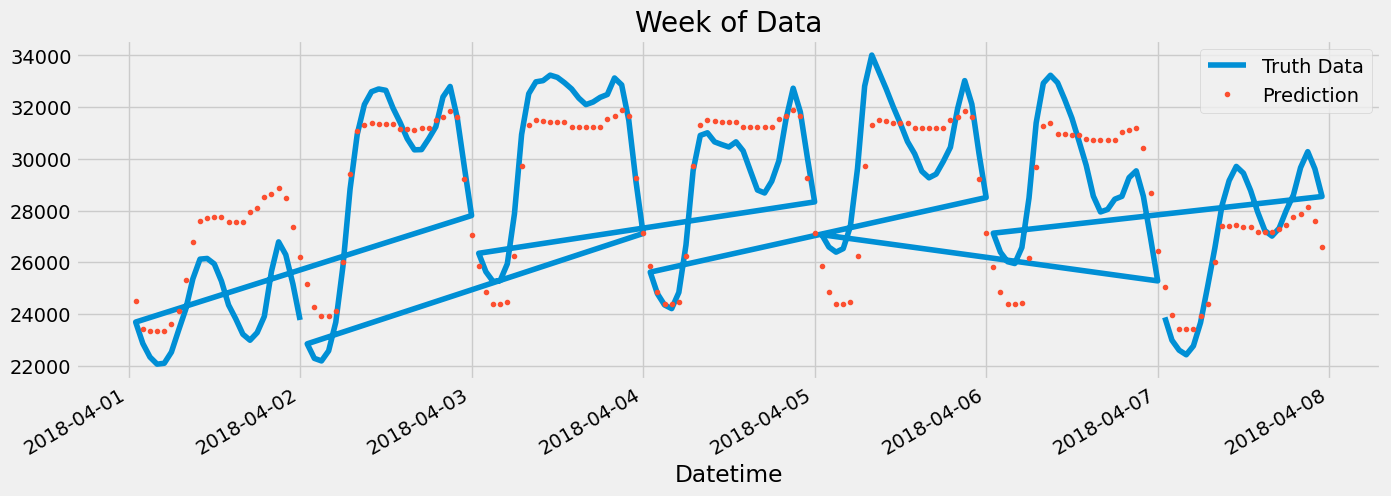

In [160]:
ax = df.loc[(df.index> '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15,5), title='Week of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [162]:
score= np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3741.03


In [167]:
test['error']=np.abs(test[TARGET] - test['prediction'])
test['date']=test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(5)

date
2016-08-13    13829.866211
2016-08-14    13577.304362
2016-09-10    11235.855143
2016-09-09    11032.220215
2016-08-12    10667.820312
Name: error, dtype: float64

In [168]:
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(5)

date
2016-12-30    395.436442
2017-10-24    413.885824
2016-10-27    440.053141
2016-04-04    440.223877
2017-05-02    453.738688
Name: error, dtype: float64